# Wilson plots generated from sparse datasets

The input data comes from the sparsification of the zenodo dataset available at:
https://zenodo.org/record/3834335

In [1]:
filename="/mnt/data/jungfrau/sparse_512_3_0_2_fit_q2.h5"
import os, time
os.chdir(os.path.dirname(filename))
start_time = time.perf_counter()

In [2]:
%matplotlib nbagg
import json, pyFAI
import hdf5plugin
import h5py
import numpy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.pyplot import subplots

In [3]:
root = h5py.File(filename, "r")
de = root.attrs["default"]
entry = root[de]
nx_data = entry[entry.attrs["default"]]
dict(nx_data)

{'background_avg': <HDF5 dataset "background_avg": shape (68, 512), type "<f4">,
 'background_std': <HDF5 dataset "background_std": shape (68, 512), type "<f4">,
 'dummy': <HDF5 dataset "dummy": shape (), type "<f8">,
 'errors': <HDF5 dataset "errors": shape (68, 512), type "<f4">,
 'frame_ptr': <HDF5 dataset "frame_ptr": shape (69,), type "<u4">,
 'index': <HDF5 dataset "index": shape (19718956,), type "<u4">,
 'intensity': <HDF5 dataset "intensity": shape (19718956,), type "<f4">,
 'mask': <HDF5 dataset "mask": shape (16448, 1030), type "<f4">,
 'radius': <HDF5 dataset "radius": shape (512,), type "<f4">,
 'script': <HDF5 dataset "script": shape (), type "|O">}

In [4]:
radius = nx_data["radius"]
I_bg = nx_data["background_avg"]
resolution = 10/numpy.sqrt(radius)
resolution[:4],resolution[-4:]

(array([30.712418, 20.798264, 16.75206 , 14.411246], dtype=float32),
 array([1.2530575, 1.251828 , 1.2506021, 1.24938  ], dtype=float32))

<IPython.core.display.Javascript object>


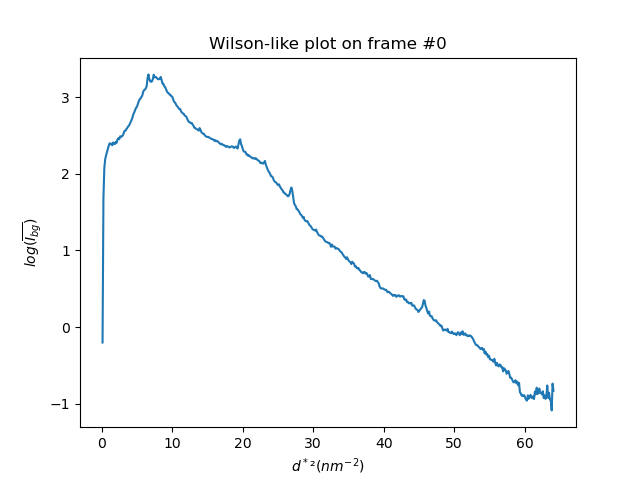

In [5]:
fig, ax = subplots()
ax.plot(radius, numpy.log(I_bg[0]))
ax.set_ylabel("$log(\overline{I_{bg}})$")
ax.set_xlabel("$d^*² (nm^{-2})$")
ax.set_title("Wilson-like plot on frame #0")
pass

<IPython.core.display.Javascript object>


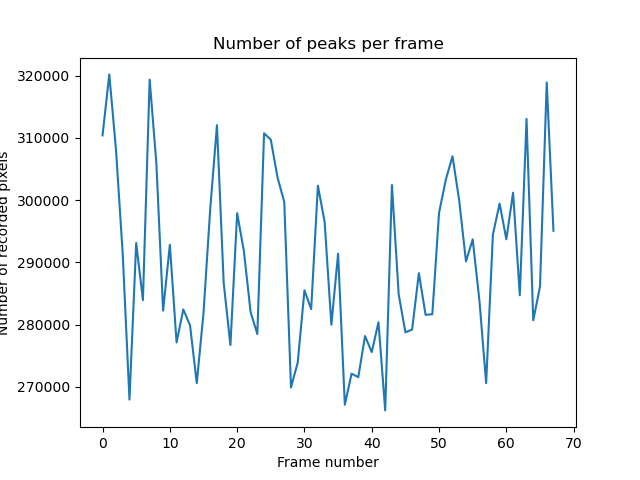

Frame index with largest number of pixel recorded: 1


In [6]:
frame_ptr = nx_data["frame_ptr"]
npix = frame_ptr[1:]-frame_ptr[:-1]
fig,ax = subplots()
ax.plot(npix)
ax.set_xlabel("Frame number")
ax.set_ylabel("Number of recorded pixels")
ax.set_title("Number of peaks per frame")
frame = numpy.argmax(npix)
print(f"Frame index with largest number of pixel recorded: {frame}")

In [7]:
mask = nx_data["mask"]
shape = mask.shape
size = numpy.prod(shape)

<IPython.core.display.Javascript object>


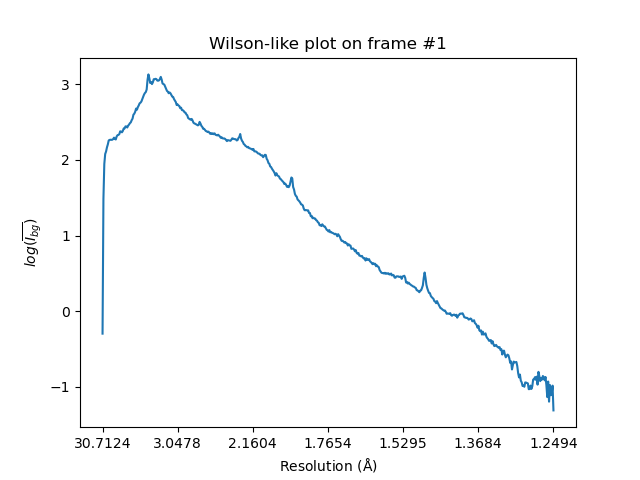

In [8]:
nticks = 7
fig, ax = subplots()
ax.plot(radius, numpy.log(I_bg[frame]), label="Background")
tick_value = numpy.linspace(radius[0], radius[-1], nticks)
ax.set_xticks(tick_value)
tick_label = [f"{10/numpy.sqrt(i) if i>0 else numpy.NaN:6.4f}" for i in tick_value]
ax.set_xticklabels(tick_label)
ax.set_xlabel("Resolution ($\mathrm{\AA}$)")
ax.set_ylabel("$log(\overline{I_{bg}})$")
ax.set_title(f"Wilson-like plot on frame #{frame}")
pass

In [9]:
indexes = nx_data["index"][frame_ptr[frame]:frame_ptr[frame+1]]
intensities= nx_data["intensity"][frame_ptr[frame]:frame_ptr[frame+1]]
signal = numpy.zeros(size)
norm = numpy.zeros(size)
signal[indexes] = intensities
norm[indexes] = 1

In [10]:
%%time
sparsify = nx_data.parent["sparsify"]
config = json.loads(sparsify["configuration/data"][()])
ai = pyFAI.load(config["geometry"])
engine = ai.setup_CSR(shape=ai.detector.shape,
                      npt=resolution.size, 
                      mask=numpy.logical_not(numpy.isfinite(mask)), 
                      unit="d*2_nm^-2",
                      split='no',
                      scale=True)

CPU times: user 8.96 s, sys: 759 ms, total: 9.72 s
Wall time: 4.74 s


In [11]:
from scipy.sparse import csr as csr_module
csr = csr_module.csr_matrix(engine.lut, shape=(resolution.size, size))
csr

<512x16941440 sparse matrix of type '<class 'numpy.float32'>'
	with 15779791 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>


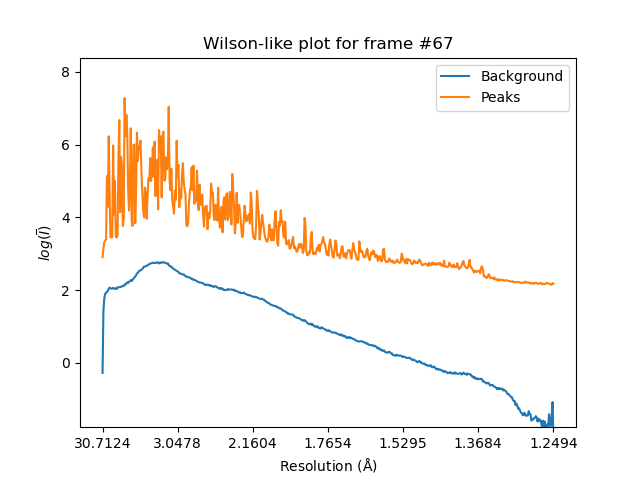

In [14]:
nticks = 7
fig, ax = subplots()
ax.plot(radius, numpy.log(I_bg[frame]), label="Background")
tick_value = numpy.linspace(radius[0], radius[-1], nticks)
ax.set_xticks(tick_value)
tick_label = [f"{10/numpy.sqrt(i) if i>0 else numpy.NaN:6.4f}" for i in tick_value]
ax.set_xticklabels(tick_label)
ax.set_xlabel("Resolution ($\mathrm{\AA}$)")
#ax.plot(radius, numpy.log(csr.dot(signal)/csr.dot(norm)-I_bg[frame]), label="Peaks-Background")
ax.plot(radius, numpy.log(csr.dot(signal)/csr.dot(norm)), label="Peaks")
ax.set_ylabel("$log(\overline{I})$")
ax.legend()
ax.set_title(f"Wilson-like plot for frame #{frame}")
pass

In [15]:
def update_plot(frame):
    ax.set_title(f"Wilson-like plot for frame #{frame}")
    ax.lines[0].set_data(radius, numpy.log(I_bg[frame]))
    signal = numpy.zeros(size)
    norm = numpy.zeros(size)
    indexes = nx_data["index"][frame_ptr[frame]:frame_ptr[frame+1]]
    intensities= nx_data["intensity"][frame_ptr[frame]:frame_ptr[frame+1]]
    signal[indexes] = intensities
    norm[indexes] = 1
    #ax.lines[0].set_data(radius, numpy.log(csr.dot(signal)/csr.dot(norm)-I_bg[frame]))
    ax.lines[1].set_data(radius, numpy.log(csr.dot(signal)/csr.dot(norm)))
    return frame
interact(update_plot, frame=widgets.IntSlider(min=0, max=len(npix)-1, step=1, value=1));

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [16]:
root.close()
print(f"Total execution time: {time.perf_counter()-start_time:6.3f} s")

Total execution time: 55.292 s
